In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

from pydrake.geometry.optimization import HPolyhedron
from pydrake.solvers import MosekSolver

from gcs.bezier import BezierGCS
from gcs.linear import LinearGCS
from models.env_2d import obstacles, vertices

savefig = 1

import os
os.environ["MOSEKLM_LICENSE_FILE"] = "/Users/nolan/mosek/mosek.lic"
MosekSolver.AcquireLicense()
print("Mosek is enabled: ", MosekSolver().enabled())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mosek is enabled:  True


# Environment setup

In [3]:
x_start = np.array([.2, .2])
x_goal = np.array([4.8, 4.8])

x_min = np.min(np.vstack(vertices), axis=0)
x_max = np.max(np.vstack(vertices), axis=0)

def make_hpolytope(V):
    ch = ConvexHull(V)
    return HPolyhedron(ch.equations[:, :-1], - ch.equations[:, -1])

regions = [make_hpolytope(V) for V in vertices]

def environment_setup():
    
    plt.figure(figsize=(3, 3))
    plt.axis('square')
    
    plt.xlim([x_min[0], x_max[0]])
    plt.ylim([x_min[1], x_max[1]])
    
    tick_gap = .2
    n_ticks = lambda x_min, x_max: round((x_max - x_min) / tick_gap) + 1
    x_ticks = np.linspace(x_min[0], x_max[0], n_ticks(x_min[0], x_max[0]))
    y_ticks = np.linspace(x_min[1], x_max[1], n_ticks(x_min[1], x_max[1]))
    plt.xticks(x_ticks)
    plt.yticks(y_ticks)
    
    label_gap = .5
    keep_label = lambda t: np.isclose(t % label_gap, 0) or np.isclose(t % label_gap, label_gap)
    x_labels = [int(t) if keep_label(t) else '' for t in x_ticks]
    y_labels = [int(t) if keep_label(t) else '' for t in y_ticks]
    plt.gca().set_xticklabels(x_labels)
    plt.gca().set_yticklabels(y_labels)
    
    plt.grid()

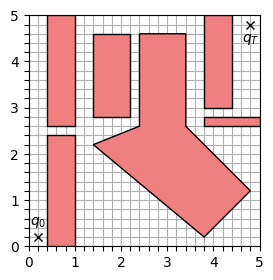

In [4]:
environment_setup()

for O in obstacles:
    plt.fill(*O.T, fc='lightcoral', ec='k', zorder=4)

plt.plot(*x_start, 'kx')
plt.plot(*x_goal, 'kx')

plt.text(.2, .35, '$q_0$', ha='center', va='bottom')
plt.text(4.8, 4.65, '$q_T$', ha='center', va='top')

if savefig:
    plt.savefig('setup.pdf', bbox_inches='tight')

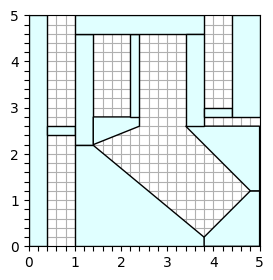

In [5]:
environment_setup()

for V in vertices:
    plt.fill(*V.T, fc='lightcyan', ec='k', zorder=4)

if savefig:
    plt.savefig('decomposition.pdf', bbox_inches='tight')

# Minimum-distance problem

In [6]:
def plot_trajectory(waypoints):

    plt.figure(figsize=(3, 3))

    for O in obstacles:
        plt.fill(*O.T, fc='lightcoral', ec='k', zorder=4)

    plt.plot(*x_start, 'kx')
    plt.plot(*x_goal, 'kx')
    plt.plot(*waypoints, 'b', zorder=5)

    plt.axis('square')
    plt.xlim([x_min[0], x_max[0]])
    plt.ylim([x_min[1], x_max[1]])
    plt.xticks(range(6))
    plt.yticks(range(6))
    plt.grid(1)

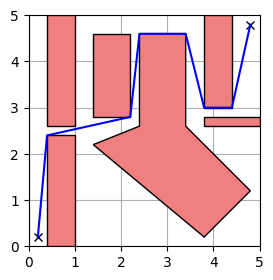

In [7]:
relaxation = True
gcs = LinearGCS(regions)
gcs.addSourceTarget(x_start, x_goal)
gcs.setSolver(MosekSolver())
waypoints = gcs.SolvePath(relaxation)[0]
plot_trajectory(waypoints)
if savefig:
    plt.savefig('linear.pdf', bbox_inches='tight')

# Minimum-time problem

In [8]:
qdot_min = -1
qdot_max = 1
n_samples = 500

def solve_bezier(order, continuity, regularizer=None, hdot_min=1e-6, velocity=None):
    
    gcs = BezierGCS(regions, order, continuity, hdot_min=hdot_min)

    gcs.addTimeCost(1)
    gcs.addVelocityLimits([qdot_min] * 2, [qdot_max] * 2)
    if regularizer is not None:
        gcs.addDerivativeRegularization(*regularizer, 2)
    gcs.addSourceTarget(x_start, x_goal, velocity=velocity)
    
    gcs.setSolver(MosekSolver())
    gcs.setPaperSolverOptions()
    
    traj = gcs.SolvePath(relaxation)[0]
    times = np.linspace(traj.start_time(), traj.end_time(), n_samples)
    waypoints = np.squeeze([traj.value(t) for t in times]).T
    velocities = np.squeeze([traj.EvalDerivative(t) for t in times]).T

    return waypoints, velocities, times

In [9]:
def plot_velocity(velocities, times, tol=np.inf):
    
    def plot_with_jumps(velocities, color):
        for i in range(len(times) - 1):
            dv = velocities[i + 1] - velocities[i]
            style = '-' if abs(dv) < tol else ':'
            plt.plot(times[i:i+2], velocities[i:i+2], color=color, linestyle=style)
            
    plt.figure(figsize=(3, 2))
            
    plot_with_jumps(velocities[0], 'tab:blue')
    plot_with_jumps(velocities[1], 'tab:orange')

    plt.xlim([times[0], times[-1]])
    plt.xticks(np.arange(int(np.ceil(times[-1] / 2))) * 2)
    plt.yticks(np.linspace(qdot_min, qdot_max, 5))
    plt.xlabel('Time $t$')
    plt.ylabel('Velocity $\dot{q}$')
    plt.grid()

Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : LO (linear optimization problem)
  Constraints            : 1541            
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 411             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 295
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 21
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 2               
Presolve term

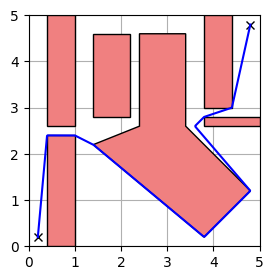

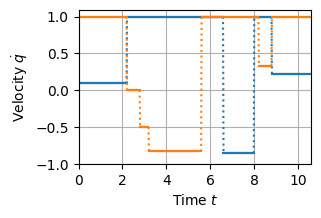

In [10]:
order = 1
continuity = 0
waypoints, velocities, times = solve_bezier(order, continuity)

plot_trajectory(waypoints)
if savefig:
    plt.savefig('bezier_10.pdf', bbox_inches='tight')

plot_velocity(velocities, times, tol=1e-1)
if savefig:
    plt.savefig('bezier_10_vel.pdf', bbox_inches='tight')

        
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 10              
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 5
Optimizer  - Cones                  : 0
Optimizer  - Scalar variables       : 10                conic                  : 0               
Optimizer  - Semi-definite variables: 0                 scalarized             : 0               
Factor     - setup time             : 0.00              dense det. time        : 0.00            
Factor     - ML order time          : 0.00              GP order time          : 0.00            
Factor     - nonzeros before factor : 14                after factor           : 14              
Factor     - dense dim.             : 0                 flops                  : 1.32e+02        
ITE PFEAS    DFEAS    GFEAS    PRSTATUS   POBJ              DOBJ              MU       TIME  
0   4.7e+02  1.1e+00  1.2e+02 

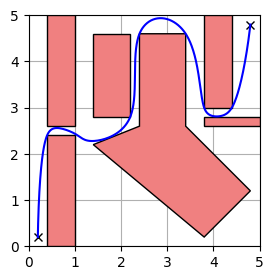

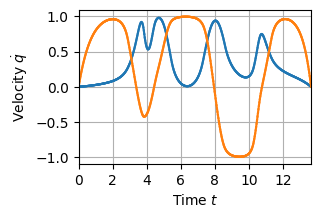

In [11]:
order = 6
continuity = 2
velocity = np.zeros((2, 2))
regularizer = [1e-1, 1e-1]
hdot_min = 1e-1
waypoints, velocities, times = solve_bezier(order, continuity, regularizer, hdot_min, velocity=velocity)

plot_trajectory(waypoints)
if savefig:
    plt.savefig('bezier_62.pdf', bbox_inches='tight')

plot_velocity(velocities, times)
if savefig:
    plt.savefig('bezier_62_vel.pdf', bbox_inches='tight')